In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image_dataset_from_directory
%load_ext tensorboard

In [2]:
BATCH_SIZE = 8
IMG_SIZE = (300, 300)

train_dataset  = tf.keras.preprocessing.image_dataset_from_directory('./aptos/preprocessed/train',
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.15, subset = 'training', seed = 1234)

Found 3662 files belonging to 5 classes.
Using 3113 files for training.


In [3]:
validation_dataset = train_dataset  = tf.keras.preprocessing.image_dataset_from_directory('./aptos/preprocessed/train',
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.15, subset = 'validation', seed = 1234)

Found 3662 files belonging to 5 classes.
Using 549 files for validation.


In [4]:
test_dataset = image_dataset_from_directory('./aptos/preprocessed/test',
                                                 shuffle = True,
                                                 batch_size = BATCH_SIZE,
                                                 image_size = IMG_SIZE)

Found 103 files belonging to 5 classes.


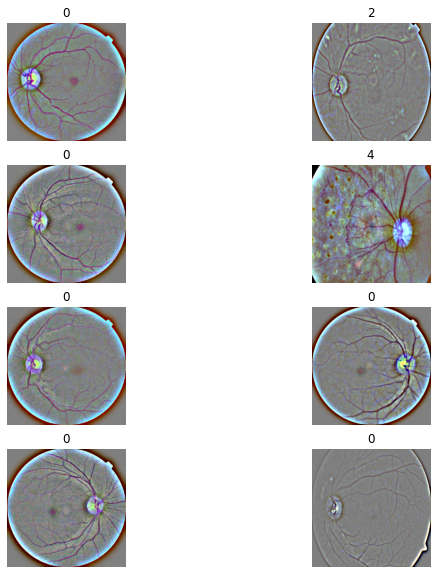

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 69
Number of test batches: 13


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)
])

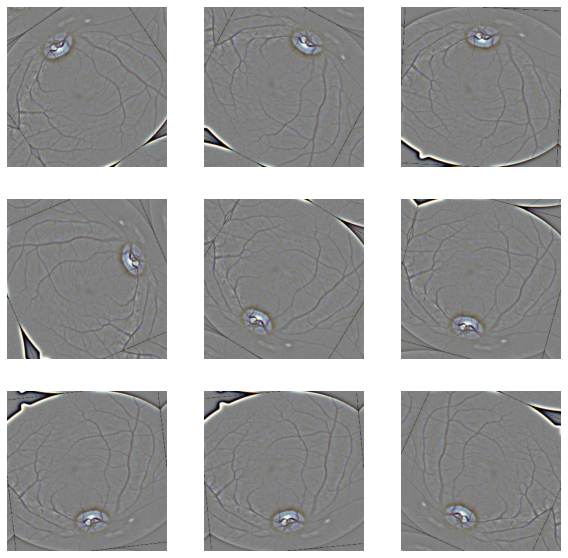

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset = -1)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB3(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 10, 10, 1536)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1536)


In [16]:
dropout1 = tf.keras.layers.Dropout(0.5)
dense1 = tf.keras.layers.Dense(2048, activation = 'relu')
dense1_output = dense1(feature_batch_average)
print(dense1_output.shape)

(8, 2048)


In [17]:
dense2 = tf.keras.layers.Dense(5, activation='softmax')
dense2_batch = dense2(dense1_output)
print(dense2_batch.shape)

(8, 5)


In [18]:
dense3 = tf.keras.layers.Dense(1, activation='linear')
dense3_batch = dense3(dense2_batch)
print(dense3_batch.shape)

(8, 1)


In [19]:
inputs = tf.keras.Input(shape = (300, 300, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = dense1(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = dense2(x)
#outputs = dense3(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer = tfa.optimizers.RectifiedAdam(lr = base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy', tfa.metrics.MultiLabelConfusionMatrix(num_classes = 5),
                       tfa.metrics.CohenKappa(num_classes = 5, sparse_labels = True)])

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3147776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)             

In [22]:
len(model.trainable_variables)

4

In [23]:
initial_epochs = 5

#loss0, accuracy0, confusion0, kappa0 = model.evaluate(validation_dataset)
loss0, accuracy0, confusion0, kappa0 = model.evaluate(validation_dataset)

69/69 [==============================] - 48s 693ms/step - loss: 1.6536 - accuracy: 0.1676 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.0092


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.65
initial accuracy: 0.17


In [26]:
import datetime
log_dir = "effb3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/5
 1/69 [..............................] - ETA: 0s - loss: 1.6771 - accuracy: 0.0000e+00 - Multilabel_confusion_matrix: 2.7500 - cohen_kappa: -0.2549WARNING:tensorflow:From /home/himangshu/anaconda3/envs/tf_ljmu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
69/69 [==============================] - 95s 1s/step - loss: 1.6159 - accuracy: 0.2222 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.0099 - val_loss: 1.4996 - val_accuracy: 0.5574 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.3307
Epoch 2/5
69/69 [==============================] - 95s 1s/step - loss: 1.3721 - accuracy: 0.5811 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.3006 - val_loss: 1.2890 - val_accuracy: 0.6740 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.4521
Epoch

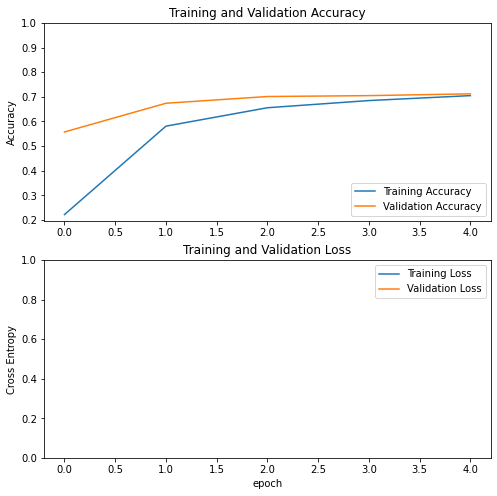

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 550

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  384


In [31]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer = tfa.optimizers.RectifiedAdam(lr = base_learning_rate / 2),
             metrics = ['accuracy', tfa.metrics.MultiLabelConfusionMatrix(num_classes = 5),
                       tfa.metrics.CohenKappa(num_classes = 5, sparse_labels = True)])

In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3147776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)             

In [33]:
len(model.trainable_variables)

4

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True, verbose=1)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./efficientb5_ckp', save_weights_only=True,
                    monitor='val_accuracy', mode='max', save_best_only=True)

callback_list = [es, rlrop, model_checkpoint, tensorboard_callback]

In [35]:
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs = total_epochs,
                        initial_epoch = history.epoch[-1],
                        validation_data = validation_dataset,
                        callbacks=callback_list)

Epoch 5/45
69/69 [==============================] - 98s 1s/step - loss: 1.2144 - accuracy: 0.7140 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5372 - val_loss: 1.2040 - val_accuracy: 0.7140 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5355
Epoch 6/45
69/69 [==============================] - 97s 1s/step - loss: 1.2133 - accuracy: 0.7049 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5207 - val_loss: 1.2014 - val_accuracy: 0.7158 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5388
Epoch 7/45
69/69 [==============================] - 92s 1s/step - loss: 1.2067 - accuracy: 0.7104 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5318 - val_loss: 1.1989 - val_accuracy: 0.7177 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5406
Epoch 8/45
69/69 [==============================] - 92s 1s/step - loss: 1.2098 - accuracy: 0.7049 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5227 - val_loss: 1.1966 - val

69/69 [==============================] - 106s 2s/step - loss: 1.1768 - accuracy: 0.7286 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5602 - val_loss: 1.1661 - val_accuracy: 0.7395 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5779
Epoch 36/45
69/69 [==============================] - 118s 2s/step - loss: 1.1733 - accuracy: 0.7377 - Multilabel_confusion_matrix: 195.2000 - cohen_kappa: 0.5770 - val_loss: 1.1659 - val_accuracy: 0.7395 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5782
Epoch 37/45
69/69 [==============================] - 120s 2s/step - loss: 1.1763 - accuracy: 0.7286 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5602 - val_loss: 1.1647 - val_accuracy: 0.7395 - val_Multilabel_confusion_matrix: 195.2500 - val_cohen_kappa: 0.5794
Epoch 38/45
69/69 [==============================] - 106s 2s/step - loss: 1.1686 - accuracy: 0.7413 - Multilabel_confusion_matrix: 195.2500 - cohen_kappa: 0.5824 - val_loss: 1.1653 - val_acc

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

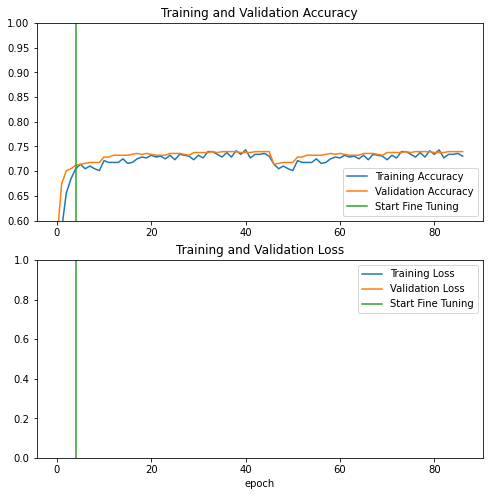

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
loss, accuracy, confusion, kappa = model.evaluate(test_dataset)
print('Test accuracy: ', accuracy)

13/13 [==============================] - 8s 610ms/step - loss: 1.4091 - accuracy: 0.4757 - Multilabel_confusion_matrix: 41.7500 - cohen_kappa: 0.2308
Test accuracy:  0.4757281541824341


In [41]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.softmax(predictions)
predictions = tf.reshape(predictions, [8, 5])
predictions = tf.argmax(predictions, 1)

Predictions:
 [2 0 2 2 2 0 0 2]
Labels:
 [2 1 2 2 3 0 3 3]


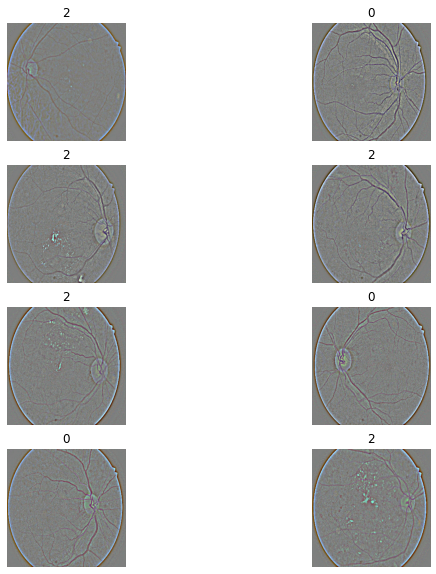

In [42]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(4, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [46]:
%tensorboard --logdir logs/effb3

Reusing TensorBoard on port 6009 (pid 130972), started 0:00:57 ago. (Use '!kill 130972' to kill it.)